# iTunes music library analysis

## A scientific way of creating playlists for fitness classes

Why... How...

I believe that the good song for the practice is the one I do not hear, or pay attention to. It gives the mood, the rhythm, the flow. But my brain should not catch it. The song should be around, not whithin.

— February 2016 —

## Summary

Bla-Bla-Bla

## Research in detail

#### Preliminaries

I use pandas and matplotlib...

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# set seaborn plot defaults
import seaborn as sns; sns.set()

# format floating point numbers
pd.set_option('float_format', '{:.2f}'.format)

The hero and the foundation of my analysis is the Echo Nest library. 

In [2]:
from pyechonest import config
config.ECHO_NEST_API_KEY="1RNDIJ5SITBKZFDCT"

### Data preparation

For this research I need two datasets. The first one is my iTunes music library. The library serves me as a test dataset. 

For the training dataset I made a list of hand picked songs and labaled each song with one of the three classes: "yoga", "cycling", and "focus". The reason I chose these categories for the training dataset is that I wanted to have two very different groups of songs ("yoga" and "cycling") and one more alike group—focus—that might sound similar to the 'yoga' group but at the same time is very different for me. I'd like to find out what song attributes make that difference.

I will start by processing the test data. iTunes xml file contains information that's stored in the iTunes database of the songs in the library. 

#### Test dataset

In [187]:
# iTunes xml file -> where does it come from?
xml_file = 'itunes_library.xml'

To parse my iTunes library xml file I use [pyItunes](https://github.com/liamks/pyitunes) module.

In [4]:
def get_itunes_song(song):
    """check the validity of the song, 
    exclude podcasts and songs 
    missing artist's name.
    """
    if (song.genre == 'Podcast' or 
        song.genre == u'iTunes U' or 
        song.kind != 'MPEG audio file' or 
        not song.artist): 
        return None 
    else:
        return song.name, song.artist

def parse_itunes_xml(db, xml_file):
    """parse xml and get song's title
    and artist's name.
    """
    from pyItunes import Library
    l = Library(xml_file)
    
    for id, song in l.songs.items():
        try:
            song_title, artist = get_itunes_song(song)
            if not db.get(song_title):
                db[song_title] = {'artist' : artist}
        except TypeError as e:
            continue

I save the data as a sqlite database (DB) and use the [sqlitedict](https://github.com/piskvorky/sqlitedict) library to access it. (Why?)

In [5]:
# DB with songs from iTunes library
from sqlitedict import SqliteDict
idb = SqliteDict('./itunes_tracks', autocommit=True)

# call parse_itunes_xml function and 
# write the data into the DB.
# TODO: uncomment
# parse_itunes_xml(idb, xml_file)

The next step is to get song attributes from the Echo Nest API.  

In the analysis I use the following track attributes:

* **Acousticness** represents the likelihood a recording was created by solely acoustic means such as voice and acoustic instruments as opposed to electronically such as with synthesized, amplified, or effected instruments;
* **Danceability** describes how suitable a track is for dancing using a number of musical elements (tempo, rhythm stability, beat strength, and overall regularity);
* **Energy** represents a perceptual measure of intensity and powerful activity released throughout the track;
* **Instrumentalnes** is a measure of how likely a song is to be instrumental;
* **Key** identifies the tonic triad, the chord, major or minor;
* **Loudness** measureas the overall loudness of a track in decibels (dB);
* **Mode** indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived;
* **Speechiness** detects the presence of spoken words in a track;
* **Tempo** is the speed or pace of a given piece (in beats per minute);
* **Time signature** specifies how many beats are in each bar (or measure);
* **Valence** describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Using the Echo Nest python library [pyechonest](https://github.com/echonest/pyechonest) is super easy and straighforward.  

The library doesn't provide data for every artist or song. I handle missing items with a "try-except" block.

In [189]:
def get_song_data(artist_name, song_title):
    """ Get track data from the Echo Nest
    database.
    """
    from pyechonest import song
    try: 
        result = song.search(artist=artist_name, 
                             title=song_title)
        song_result = result[0]
        song_data = song_result.audio_summary
        return song_data
    
    except IndexError as e:
        print 'No data for the song', song_title
        return None
    
def add_song_data_to_db(song_title, song_data, db):
    """ Add song data we get from Echo Nest 
    to the DB.
    """
    song_val = {'time_signature' : song_data['time_signature'],
                'energy' : song_data['energy'],
                'tempo' : song_data['tempo'], 
                'speechiness' : song_data['speechiness'],
                'acousticness' : song_data['acousticness'], 
                'danceability' : song_data['danceability'],
                'instrumentalness' : song_data['instrumentalness'],
                'key' : song_data['key'],
                'loudness' : song_data['loudness'],
                'valence' : song_data['valence'],
                'mode' : song_data['mode']}
    value = db[song_title]
    value.update(song_val)
    db[song_title] = value
    
# TODO: add_song_data should return value, the db update happens in a single place        
def set_echonest_attributes(db):
    """Look for new songs in the DB and get 
    song attributes from the Echo Nest library.
    """
    from time import sleep

    for song_title, value in db.iteritems():
        # Check if the attributes have been already added
        if value.get('tempo') or value.get('No_data'): 
            pass
        else:
            song_data = get_song_data(value['artist'], 
                                      song_title)
            # If the song is in the Echo Nest base, 
            # I add the data to the DB.
            if song_data:
                add_song_data_to_db(song_title, 
                                    song_data, db)
            # If not, I add 'No_data' key to the song. 
            else:
                song_val = {'No_data' : True}
                value.update(song_val)
                db[song_title] = value
            # Echo Nest limits number of requests to 20 per minute
            sleep(8) 

In [7]:
# Call check_data_in_db function and 
# write the Echo Nest data into the DB.

# set_echonest_attributes(idb)

#### Training dataset

I use Pandas read_csv function to read csv file and write it into the sqlite dictionary. (What csv file? Where does it come from? make DataFrame.head of it)

    chosen_tracks_df = pd.read_csv('my_shiny_file_of_chosen_tracks.csv')
    chosen_tracks_df.head()

In [8]:
train_db = SqliteDict('./chosen_tracks', autocommit=True)

In [9]:
# Call check_data_in_db function and 
# write the Echo Nest data into the DB.

# set_echonest_attributes(train_db)

## Data overview  
  
Now I have two sets with song data. Next I read in data from both databases and take a look at what I'm working with.

In [10]:
def read_db_in_pandas(db):
    """ Read the DB and return 
    cleaned version.
    """
    # transpose data to have dict keys (song names) 
    # as index
    df = pd.DataFrame(dict(db)).T
    
    # remove rows with no data for a song
    df_clean = df[df['No_data'] != 1]
    
    # convert columns into numbers
    df_clean = df_clean.convert_objects(convert_numeric=True)

    # convert index into a column
    df_clean.reset_index(level=0, inplace=True)
    df_clean.rename(columns = {'index': 'song_title'}, 
                    inplace=True)
    
    # remove the 'No_data' column
    df_clean.drop('No_data', 1, 
                  inplace=True)
    return df_clean

### Test data

In [11]:
test_df = read_db_in_pandas(idb)

In [12]:
# format floating point numbers 
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

print ("There are {0} items in the dataset."
       .format(len(idb)))
print ("{0} items have no data available " 
       "in the Echo Nest DB."
       .format(len(idb) - len(test_df)))
print ("We are left with {0} songs to use as a test set."
       .format(len(test_df)))
print "\nBelow is a random sample of the dataset."
test_df.sample(n=4)

There are 554 items in the dataset.
223 items have no data available in the Echo Nest DB.
We are left with 331 songs to use as a test set.

Below is a random sample of the dataset.


,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
329,trust me,0.10,The Streets,0.64,0.99,0.00,1,-3.21,1,0.23,120.04,4,0.78
248,Stylo,0.01,Gorillaz,0.68,0.62,0.00,10,-9.06,0,0.06,100.23,4,0.85
271,The Wind,0.34,PJ Harvey,0.67,0.21,0.80,4,-29.23,0,0.04,110.01,4,0.51
256,Take,0.66,tunng,0.74,0.43,0.00,1,-10.33,0,0.05,120.06,4,0.25


I visualize the data to see if there are any patterns. I can change index (x_index, y_index) in simple_df_plot function to see the relationship between different variables (e.g. DataFrame column index).

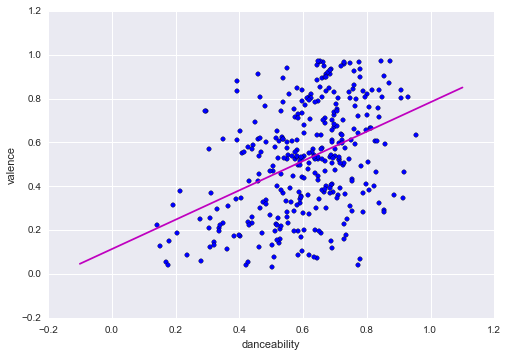

In [190]:
def simple_df_plot(df, x_index, y_index):
    # list columns with numeric values
    cols = df.select_dtypes(exclude=[object]).columns
    x = df[cols[x_index]]
    y = df[cols[y_index]]
    
    plt.scatter(x, y)
    plt.clim(0, 1.5)
    plt.xlabel(cols[x_index])
    plt.ylabel(cols[y_index]);
    
    # add a trendline
    from scipy.stats import linregress
    regressionline = linregress(x, y)
    slope = regressionline[0]
    intercept = regressionline[1]
    z = np.linspace(-0.1, 1.1, 100)
    plt.plot(z, slope*z + intercept, 'm')
    
# make a plot of (1 - danceability, 10 - valence)
simple_df_plot(test_df, 1, 10)

It seems there's a correlation between danceability (x_index = 1) of the track and its valence (y_index = 10), which sounds reasonable. 

I've also noticed that there is a negative correlation between acousticness (x_index = 0) and energy (y_index = 2): the higher the enegry of the track is the lower is its acousticness. 

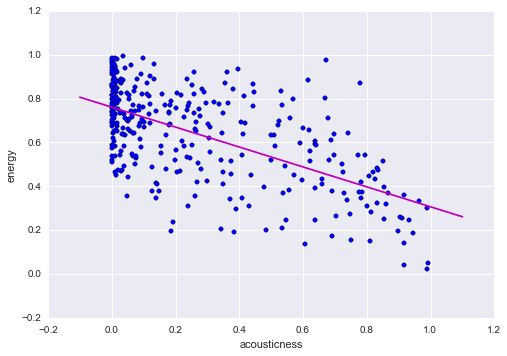

In [15]:
simple_df_plot(test_df, 0, 2)

I'll explore this later... Let's move on to the training data. (TODO: Need a conclusion here instead.)


### Training data

In [191]:
train_df = read_db_in_pandas(train_db) # TODO: need short description how the data has been acquired.

In [17]:
print ("There are {0} items in the dataset."
       .format(len(train_db)))
print ("{0} items have no data available "
       "in the Echo Nest DB."
       .format(len(train_db) - len(train_df)))
print ("We are left with {0} songs to use as training data."
       .format(len(train_df)))
print "\nBelow is a random sample of the dataset."
train_df.sample(n=4)

There are 128 items in the dataset.
37 items have no data available in the Echo Nest DB.
We are left with 91 songs to use as training data.

Below is a random sample of the dataset.


,song_title,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
12,Bless This Morning Year,0.96,Helios,yoga,0.55,0.17,0.93,3,-16.83,0,0.03,100.00,4,0.04
71,TV Queen,0.00,Wild nothing,cycling,0.44,0.86,0.21,9,-5.90,1,0.05,134.95,4,0.72
51,Narayani A,0.83,Suns of Arqa,yoga,0.36,0.41,0.88,9,-12.99,1,0.03,110.00,3,0.15
86,Where you at,0.00,The Bohicas,cycling,0.44,0.92,0.10,0,-5.31,1,0.06,172.99,4,0.71


In [18]:
# list of categories
categories = list(pd.unique(train_df.category.ravel()))
print ("Tracks in the dataset belong " 
       "to {} categories: {}."
       .format(len(categories), ", ".join(categories)))

# count tracks in each category
cat_count = pd.value_counts(train_df.category.ravel())

# print categories
for category in categories:
    print ("{} tracks represent \'{}\' category."
           .format(cat_count[category], category))

Tracks in the dataset belong to 3 categories: cycling, focus, yoga.
26 tracks represent 'cycling' category.
34 tracks represent 'focus' category.
31 tracks represent 'yoga' category.


I'll compare the three groups. 

In [192]:
# TODO: Should use groupby function

def group_and_describe(category):
    # describe each category
    group = train_df[train_df['category'] == category]
    group_descr = group.describe(percentiles=None).loc[['mean', 'std']]
    return group_descr

grouped_df = [group_and_describe(category) for category in categories]

result = pd.concat(grouped_df, 
                   keys=categories, 
                   names=['category', 'measures'])
# sort the table to make it more readable
result.sortlevel(level=1).reorder_levels(['measures', 'category'])

acousticness  danceability  energy  instrumentalness  key  \
measures category                                                              
mean     cycling           0.11          0.60    0.79              0.08 5.58   
         focus             0.56          0.33    0.33              0.88 6.09   
         yoga              0.84          0.44    0.19              0.81 5.84   
std      cycling           0.22          0.14    0.14              0.19 4.06   
         focus             0.37          0.23    0.23              0.16 3.71   
         yoga              0.22          0.19    0.14              0.25 2.97   

                   loudness  mode  speechiness  tempo  time_signature  valence  
measures category                                                               
mean     cycling      -5.97  0.77         0.06 136.66            4.00     0.70  
         focus       -19.40  0.56         0.05 113.51            3.76     0.21  
         yoga        -19.55  0.68         0.04 110.50            3.39     0.23  
std      cycling       2.51  0.43         0.03  22.40            0.00     0.21  
         focus         6.69  0.50         0.03  38.17            0.85     0.20  
         yoga          5.85  0.48         0.01  27.25            1.05     0.21

This table gives...  
Next step is to visualize the data. (TODO: visualize the table above)

First I create a new column in the DF where I'll assign a numeric class to each track.

In [193]:
def label_categories(row):
    # make a list of categories
    categories = list(pd.unique(train_df.category.ravel()))
    for item in categories:
        if row['category'] == item:
            return categories.index(item) 
        
train_df['num_cat'] = train_df.apply(lambda row: label_categories(row), axis=1)

Let's plot the data. (TODO: explain. Let's plot what?)

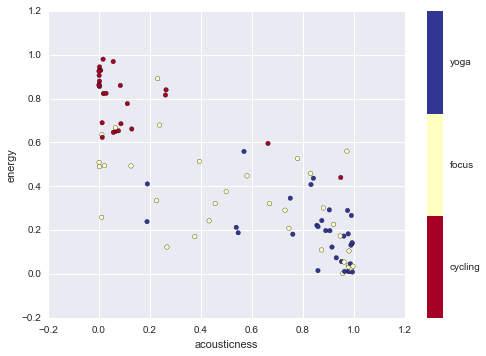

In [21]:
def plot_df_categories(df, x_index, y_index):
    # list columns with numeric values
    cols = df.select_dtypes(exclude=[object]).columns
    
    # list of categories
    cat_li = np.sort(df.category.unique()).tolist()
    # the formatter will label the colorbar with categories
    formatter = plt.FuncFormatter(lambda i, 
                                   *args: cat_li[int(i)])
    plt.scatter(df[cols[x_index]], 
                df[cols[y_index]],
                c=df.num_cat, 
                cmap=plt.cm.get_cmap('RdYlBu', 3))
    plt.colorbar(ticks=[0, 1, 2], 
                 format=formatter)
    plt.clim(-0.5, 2.5)
    plt.xlabel(cols[x_index])
    plt.ylabel(cols[y_index]);
    
#plot the data
plot_df_categories(train_df, 0, 2)

As expected, 'yoga' and 'cycling' form two separate groups. Tracks in the 'cycling' group tend to be more energetic and less acoustic. Tracks in the 'yoga' groupd have high level of acousticness and low level of energy. 

Ironically, the 'focus' class is the least focused. (TODO: add more plots from plot_df_categories -OR- add multi scatterplot)

### Cleaning data

Before I start working with scikit-learn library, I need to rearrange both datasets a bit. (TODO: Why?)
#### — Training set —

In [22]:
# Training dataset

# target data
target = train_df.num_cat

# keep only numerical values
cols = train_df.select_dtypes(exclude=[object]).columns
train_matrix = train_df[cols]

# remove target column
train_matrix = train_matrix.drop(['num_cat'], axis=1)

# standardize features
train_matrix = train_matrix.apply(lambda x: (x - np.mean(x)) 
                                               / np.std(x))
# review the set
train_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,0.34,-0.25,0.60,-1.57,-1.38,0.71,0.72,-0.79,2.20,0.36,0.73
1,0.63,-1.24,0.37,0.91,1.17,-0.38,-1.39,1.47,-0.10,0.36,-1.05
2,1.12,-1.57,-1.34,0.84,0.04,-1.67,0.72,-0.46,-0.97,0.36,-1.07
3,0.76,-1.03,0.15,0.77,-1.38,-0.46,0.72,-0.49,-0.92,0.36,-0.46
4,1.16,-1.21,-0.92,0.81,0.89,-0.49,-1.39,-0.44,0.48,0.36,-1.07


#### — Test set —

In [23]:
# keep only numerical values
cols = test_df.select_dtypes(exclude=[object]).columns
test_matrix = test_df[cols]

# standardize features
test_matrix = test_matrix.apply(lambda x: (x - np.mean(x)) 
                                / np.std(x))

# review the dataset
test_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,-0.91,-0.03,0.72,-0.37,-0.31,0.24,-1.13,-0.48,-0.78,0.15,0.48
1,0.41,-1.91,-1.60,1.75,1.33,-0.54,-1.13,-0.45,0.95,-3.33,-0.60
2,1.84,1.24,-1.53,1.78,0.51,-1.38,0.89,-0.20,0.52,0.15,0.80
3,-0.80,-2.01,0.13,-0.74,1.06,0.44,0.89,-0.29,0.24,-3.33,0.89
4,1.35,-1.85,-1.06,1.57,-1.40,-2.67,-1.13,-0.18,-0.09,0.15,-1.50


Finally, we convert the processed training data from a Pandas dataframe into a numerical (Numpy) array. (TODO: Why?)

In [197]:
train_data = np.nan_to_num(train_matrix.values)
test_data = np.nan_to_num(test_matrix.values)

## Novelty detection

I start my analysis with choosing tracks from the test set that match classes in the training set. For this purpose I use one-class SVM unsupervised algorithm (TODO: link the algo). One-class SVM is used for novelty detection, that is, given a set of samples (training set), it will detect the soft boundary of that set so as to classify new points (test set) as belonging to that set or not.

It's important to point out that the algorithm treats the training data as not polluted by outliers.

I use radial basis function, or 'rbf', kernel; 'nu' value has been chosen by trial and error method. (TODO: add short nu description)

In [25]:
from sklearn import svm

# fit the model
svm_model = svm.OneClassSVM(kernel="rbf", nu=0.07)
svm_model.fit(train_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.07, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [26]:
# new observations, or test data, can now be sorted 
# as inliers or outliers with a predict method
y_pred_test = svm_model.predict(test_data)

# number of tracks outside set boudaries
# inliers are labeled 1, while outliers are labeled -1
n_error_test = y_pred_test[y_pred_test == -1].size

In [27]:
print ("Number of tracks that match the training set: {0}."
       "\nNumber of tracks outside set boudaries: {1}."
       .format((y_pred_test.size - n_error_test), 
               n_error_test))

Number of tracks that match the training set: 185.
Number of tracks outside set boudaries: 146.


### Plot the result
(TODO: add "it's hard to plot 11-dimention array (whatever) to 2d plot so... ) To visualtise the algorithm I first need to perform dimensionality reduction first. I use Principal Component Analysis, or PCA to transform the set to 2 dimensions. 

In [28]:
# apply PCA to the training set
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
X = pca.fit_transform(train_data)

# print the result
print "Original dataset shape:", train_data.shape
print "Reduced dataset shape:", X.shape

Original dataset shape: (91, 11)
Reduced dataset shape: (91, 2)


Meaning of the 2 components:
-0.392 x acousticness + 0.311 x danceability + 0.421 x energy + -0.392 x instrumentalness + -0.021 x key + 0.425 x loudness + 0.076 x mode + 0.152 x speechiness + 0.214 x tempo + 0.142 x time_signature + 0.377 x valence
0.218 x acousticness + 0.180 x danceability + -0.097 x energy + -0.044 x instrumentalness + -0.674 x key + -0.056 x loudness + 0.398 x mode + -0.476 x speechiness + 0.182 x tempo + -0.016 x time_signature + 0.182 x valence


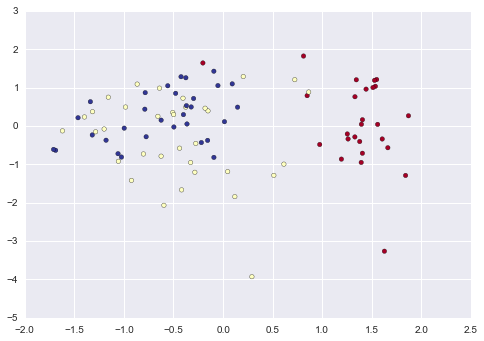

In [29]:
import pylab as pl
pl.scatter(X[:, 0], X[:, 1], 
           c=target, cmap='RdYlBu')

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            train_matrix.columns)))

This plot gives an idea of the relationship between the classes. Essentially, the PCA algorithm found the optimal stretch and rotation in 11-dimensional space that allows to see the layout of classes.

Apply PCA to the test set.

In [198]:
# apply PCA to the test set
y = pca.fit_transform(test_data)

# print the result
print "Original dataset shape:", test_data.shape
print "Reduced dataset shape:", y.shape

Original dataset shape: (331, 11)
Reduced dataset shape: (331, 2)


(TODO: Why refit svm_model?)

In [31]:
# fit the OneClassSVM model
# 2D data
svm_model.fit(X)
y_pred_train2d = svm_model.predict(X)
y_pred_test2d = svm_model.predict(y)
# n_error_train = y_pred_train[y_pred_train == -1].size
# n_error_test = y_pred_test[y_pred_test == -1].size

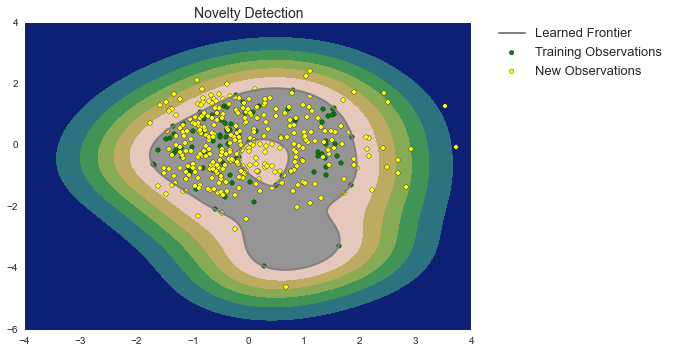

In [32]:
# make a plot 

h = 0.02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 4, X[:, 0].max() + 6
y_min, y_max = X[:, 1].min() - 3, X[:, 1].max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection", {'fontsize': 14})

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.gist_earth)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='grey')
plt.contourf(xx, yy, Z, levels=[0, Z.max()])

b1 = plt.scatter(X[:, 0], X[:, 1], c='green') # train set
b2 = plt.scatter(y[:, 0], y[:, 1], c='yellow') # test set
plt.axis('tight')
plt.xlim((-4, 4))
plt.ylim((-6, 4))
plt.legend([a.collections[0], b1, b2],
           ["Learned Frontier", "Training Observations",
            "New Observations"], bbox_to_anchor=(1.05, 1), borderaxespad=0.,
           loc=2,
           prop=matplotlib.font_manager.FontProperties(size=13))
plt.show()

In [33]:
# To-do: Summary

### Save the results

Next step is to classify tracks that match the training set.  
First, I record the result of novelty detection algorithm to the test dataframe and to the test set. 

In [34]:
# add to the DF
match = pd.DataFrame({'match': y_pred_test})
test_result_df = pd.concat([test_df, match], axis=1)
test_result_df.head()

,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,match
0,ADDICTIVE,0.00,Faithless,0.60,0.79,0.14,4,-8.00,0,0.03,98.97,4,0.64,1.00
1,ANOTHER NIGHT IN,0.39,TINDERSTICKS,0.31,0.30,0.85,10,-11.28,0,0.03,142.21,3,0.37,-1.00
2,After All Is Said and Done,0.80,Junip,0.80,0.31,0.86,7,-14.80,1,0.05,131.53,4,0.72,-1.00
3,All My Loving,0.04,The Beatles,0.30,0.67,0.01,9,-7.17,1,0.04,124.46,3,0.74,-1.00
4,Almost Fell,0.66,Nicolas Jaar,0.32,0.41,0.79,0,-20.17,0,0.05,116.17,4,0.14,-1.00


In [35]:
# add novelty results to the set
# convert y_pred_test from a 1d array into a 2d array
print 'Before:', y_pred_test.shape
print 'After the magic: ', y_pred_test[:, None].shape
print 'Test set shape: ', test_data.shape

Before: (331,)
After the magic:  (331, 1)
Test set shape:  (331, 11)


In [36]:
# create new array with results
post_svm_test = np.concatenate((test_data, y_pred_test[:, None]), 1)
post_svm_test.shape

(331, 12)

In [37]:
# add index to the set
set_index = np.asarray(range(331))[:, None]
post_svm_test = np.concatenate((set_index, post_svm_test), 1)

# review the result 
post_svm_test[:3]

array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ],
       [ 1.        ,  0.4141471 , -1.91387049, -1.6011356 ,  1.74694552,
         1.33281141, -0.54391301, -1.12566571, -0.44520947,  0.9529425 ,
        -3.32818717, -0.60456148, -1.        ],
       [ 2.        ,  1.83629482,  1.24130056, -1.53144213,  1.77772202,
         0.51179297, -1.3826734 ,  0.88836321, -0.20106329,  0.52414909,
         0.14698618,  0.80421917, -1.        ]])

In [38]:
# keep only matching items
matching_test = post_svm_test[post_svm_test[:, 12] == 1]

# review the result
matching_test.shape

(185, 13)

## Classification

I'm going to compare the result of three different models:
1. K nearest neighbors classification
2. Random Forest Classification
3. SVC

The algorithm I use is as follows:
1. Tune parameters using GridSearchCV.  
I use GridSearchCV to test the desired range of input parameters, and review the performance of each set of values on a cross-validation basis. 
2. Create and train the model.
3. Estimate model accuracy score.
4. Record the result to the set and DF.
5. Estimate classification probability.
6. Review the results.

### K nearest neighbors
#### 1. Tune parameters with GridSearchCV

In [39]:
from sklearn import neighbors
from sklearn.grid_search import GridSearchCV

# tune parameters
parameter_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}
grid_search = GridSearchCV(neighbors.KNeighborsClassifier(), parameter_grid,
                            cv=5, verbose=3)

grid_search.fit(train_data, target)

# review the result
grid_search.grid_scores_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.650000 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.777778 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.611111 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.611111 -   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.588235 -   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........ n_neighbors=3, weights=distance, score=0.650000 -   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV] ........ n_n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished



[CV] n_neighbors=7, weights=uniform ..................................
[CV] ......... n_neighbors=7, weights=uniform, score=0.600000 -   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ......... n_neighbors=7, weights=uniform, score=0.722222 -   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ......... n_neighbors=7, weights=uniform, score=0.722222 -   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ......... n_neighbors=7, weights=uniform, score=0.777778 -   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ......... n_neighbors=7, weights=uniform, score=0.705882 -   0.0s
[CV] n_neighbors=7, weights=distance .................................
[CV] ........ n_neighbors=7, weights=distance, score=0.600000 -   0.0s
[CV] n_neighbors=7, weights=distance .................................
[CV] ........ n_neighbors=7, weights=distance, score=0.722222 -   0.0s
[CV] 

[mean: 0.64835, std: 0.06803, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.65934, std: 0.06151, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.68132, std: 0.03381, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.68132, std: 0.03381, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.70330, std: 0.05816, params: {'n_neighbors': 7, 'weights': 'uniform'},
 mean: 0.69231, std: 0.05923, params: {'n_neighbors': 7, 'weights': 'distance'}]

In [40]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

knn_best_score = grid_search.best_score_
best_params = grid_search.best_params_

# print the winner
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nBest parameters: {1}."
       .format(knn_best_score, 
               best_params
              ))

The best-performing tuning parameters
Best score: 0.703296703297;
Best parameters: {'n_neighbors': 7, 'weights': 'uniform'}.


#### 2. Create and train the model

In [41]:
# create the model
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, 
                                     weights=weights)

# train the model
knn.fit(train_data, target)

# make predictions
def make_predictions(model):
    # exclude index and novelty result
    output = model.predict(matching_test[:, 1:12])
    return output

knn_output = make_predictions(knn)

#### 3. Estimate model accuracy score

In [149]:
def model_cross_valid(model):
    """Calculate model accuracy score
    using 2-fold cross-validation
    """
    from sklearn.cross_validation import cross_val_score

    cv = cross_val_score(model, train_data, target, 
                         scoring='accuracy', cv=10)

    # calculate model accuracy score
    acc_score = cv.mean()

    return acc_score

def model_cross_report(model):
    """Build a text report showing 
    the main classification metrics
    """
    from sklearn.cross_validation import cross_val_predict
    
    predicted = cross_val_predict(model, train_data, 
                                  target, cv=10)
    
    return classification_report(target, predicted, 
                                 target_names=categories)

print "Model accuracy score: ", round(model_cross_valid(knn), 4)
print "Model report \n", 
print model_cross_report(knn)

Model accuracy score:  0.709
Model report 
             precision    recall  f1-score   support

    cycling       0.89      0.96      0.93        26
      focus       0.65      0.50      0.57        34
       yoga       0.59      0.71      0.65        31

avg / total       0.70      0.70      0.70        91



#### 4. Record the result

In [43]:
# add the result to the matching set
knn_set = np.concatenate((matching_test, knn_output[:, None]), 1)

# review the result
print knn_set.shape
print "\nSample of the resulting set: "
knn_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  2.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ]])

#### 5. Estimate probability

In [44]:
def class_proba(model):
    """Calculate probability for 
    every class and return an array
    with highest probability for each
    track. 
    """
    probability = model.predict_proba(matching_test[:, 1:12])
    
    # make a list of highest probabilities
    max_proba = np.asarray([x.max() for x in probability])
    return max_proba[:, None]

In [45]:
# kNN classification probability
max_proba = class_proba(knn)

# add probability to the set
knn_set = np.concatenate((knn_set, max_proba), 1)

#### 6. Review the result
I transform the set back into pandas dataframe for easier manipulations.

In [162]:
def review_df(dataset):
    """Transform dataset into a df.
    Return the df.
    """
    # make a list of column names
    li = (['index'] + 
          train_matrix.columns.tolist() + 
          ['match', 'num_cat', 'probability'])
    
    # transform set into a DF
    df = pd.DataFrame(dataset, columns=li)
    
    # change column type to integer
    df[['index', 'match', 'num_cat']] = df[['index', 'match', 'num_cat']].astype(int)
    
    # change index to the original index
    df = df.set_index(['index'])

    return df


def model_summary(df, model, model_name):
    print ("Summary of the {} algorithm "
           "performance\n".format(model_name))
    print "Model: "
    print model
    print ("\nAccuracy score: {}"
           .format(round(model_cross_valid(model), 
                         4)))
    
    # drop 'match' column as it's not relevant here
    df = df.drop(match, 1)
    print ("\nNumber of tracks in the test set: {}."
           .format(len(df)))
    for category in categories:
        print ("Number of tracks assigned to the \"{}\" class: {}."
               .format(category, 
                      len(df[df['num_cat'] == categories.index(category)])))
    print "\nMean probability for each category"
    grouped = df.groupby(['num_cat'])
    print grouped['probability'].mean()

In [163]:
knn_df = review_df(knn_set)
model_summary(knn_df, knn, 'K-Nearest Neighbors')

Summary of the K-Nearest Neighbors algorithm performance

Model: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=7, p=2, weights='uniform')

Accuracy score: 0.709

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 87.
Number of tracks assigned to the "focus" class: 48.
Number of tracks assigned to the "yoga" class: 50.

Mean probability for each category
num_cat
0   0.75
1   0.58
2   0.68
Name: probability, dtype: float64


As expected, the most certain class is "cycling" and the least "focused" is the "focus" class. 
Now let's add a minimum value for probability (70%) and review the result. 

In [165]:
# add a minimum value for probability
def high_proba_df(df, threshold):
    """Returns a df with class probability
    higher than a threshold
    """
    # drop 'match' column as it's not relevant here
    df = df.drop(match, 1)
    
    high_proba = df[df['probability'] >= threshold]
    return high_proba

def sum_category(df, index):
    """Returns number of tracks in a category
    """
    category_size = len(df[df['num_cat'] == index])
    return category_size 
    
def print_summary_of_high_proba(df):
    print ("Number of tracks with high probability "
          "of being assiged to a correct class: {}."
          .format(len(df)))
    print "Among which..."
    for category in categories:
        print ("...assigned to the \"{}\" class: {}."
               .format(category, 
                      len(df[df['num_cat'] == categories.index(category)])))
    print "\nMean probability for each category"
    grouped = df.groupby(['num_cat'])
    print grouped['probability'].mean()

In [166]:
# print summary 
print_summary_of_high_proba(high_proba_df(knn_df, 0.7))

Number of tracks with high probability of being assiged to a correct class: 108.
Among which...
...assigned to the "cycling" class: 60.
...assigned to the "focus" class: 15.
...assigned to the "yoga" class: 33.

Mean probability for each category
num_cat
0   0.86
1   0.73
2   0.75
Name: probability, dtype: float64


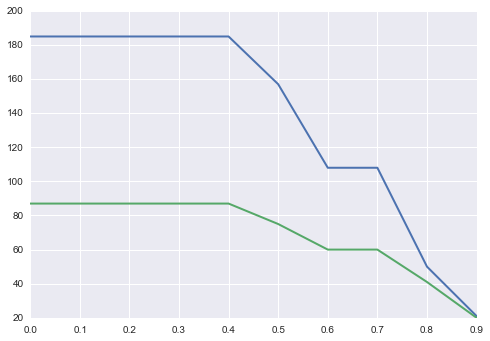

In [185]:
# plot
xs = list(a / 10.0 for a in range(10))

# all classes
total = [len(high_proba_df(knn_df, i)) for i in xs]
line_total = plt.plot(xs, total, linewidth=2)

# cycling class
cycling_class = [sum_category(high_proba_df(knn_df, i), 0) for i in xs]
line_cycling = plt.plot(xs, cycling_class, linewidth=2)

plt.show()

### Random Forest Classifier

The next model I use is Random Forest Classifier. 

#### 1. Tune parameters with GridSearchCV
I start with GridSearchCV parameter tuning to choose the optimal number of features considered at each step a branch is made (max_features: 50%, 70% or 100% of features) and the maximum number of branches (max_depth: 5 levels, 8 levels or no limitations).

In [174]:
list(x / 10.0 for x in range(10))

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [67]:
from sklearn.ensemble import RandomForestClassifier

# tune parameters
parameter_grid = {
    'max_features': [0.5, 0.7, 1.],
    'max_depth': [5., 8., None]
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators = 100), 
                           parameter_grid, 
                           cv=5, verbose=3)

grid_search.fit(train_data, target)

# review the results
grid_search.grid_scores_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.700000 -   0.1s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.833333 -   0.1s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.777778 -   0.2s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.722222 -   0.2s
[CV] max_features=0.5, max_depth=5.0 .................................
[CV] ........ max_features=0.5, max_depth=5.0, score=0.823529 -   0.1s
[CV] max_features=0.7, max_depth=5.0 .................................
[CV] ........ max_features=0.7, max_depth=5.0, score=0.700000 -   0.1s
[CV] max_features=0.7, max_depth=5.0 .................................
[CV] ........ max

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    3.8s



[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.666667 -   0.2s
[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.777778 -   0.1s
[CV] max_features=0.5, max_depth=None ................................
[CV] ....... max_features=0.5, max_depth=None, score=0.823529 -   0.1s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.700000 -   0.1s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.833333 -   0.1s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.722222 -   0.1s
[CV] max_features=0.7, max_depth=None ................................
[CV] ....... max_features=0.7, max_depth=None, score=0.666667 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.1s finished


[mean: 0.76923, std: 0.05312, params: {'max_features': 0.5, 'max_depth': 5.0},
 mean: 0.73626, std: 0.05600, params: {'max_features': 0.7, 'max_depth': 5.0},
 mean: 0.70330, std: 0.07022, params: {'max_features': 1.0, 'max_depth': 5.0},
 mean: 0.74725, std: 0.06718, params: {'max_features': 0.5, 'max_depth': 8.0},
 mean: 0.73626, std: 0.05600, params: {'max_features': 0.7, 'max_depth': 8.0},
 mean: 0.68132, std: 0.04139, params: {'max_features': 1.0, 'max_depth': 8.0},
 mean: 0.73626, std: 0.05600, params: {'max_features': 0.5, 'max_depth': None},
 mean: 0.74725, std: 0.06718, params: {'max_features': 0.7, 'max_depth': None},
 mean: 0.72527, std: 0.09038, params: {'max_features': 1.0, 'max_depth': None}]

In [68]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

# print the winner
rfc_best_score = grid_search.best_score_
best_params = grid_search.best_params_
max_features = best_params['max_features']
max_depth = best_params['max_depth']
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nMax features: {1}%;"
       "\nMax depth: {2}."
       .format(rfc_best_score, 
               max_features*100,
              max_depth))

The best-performing tuning parameters
Best score: 0.769230769231;
Max features: 50.0%;
Max depth: 5.0.


#### 2. Create and train the model

In [100]:
# create the model
rfc = RandomForestClassifier(n_estimators=100, 
                             random_state=0,
                             max_features=max_features, 
                             max_depth=max_depth)

# train the model
rfc.fit(train_data, target)

# make predictions
rfc_output = make_predictions(rfc)

#### Random Forest Visualization
To visualize the model I apply the function that was used by Jake VanderPlas for his [Scikit-learn tutorial](https://github.com/jakevdp/sklearn_pycon2015) at PyCon 2015.

In [101]:
# the function
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    
    # clone the estimator to apply it to a 2d data
    from sklearn.base import clone
    model = clone(estimator)
    model.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = model.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

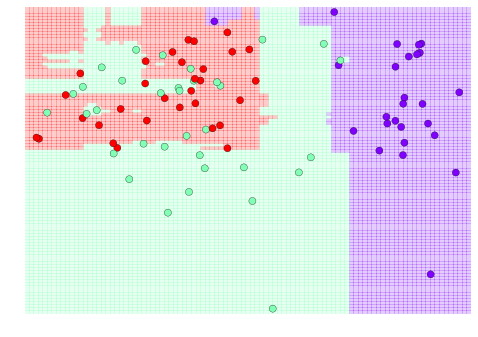

In [109]:
# I use previously processed test set 
# with reduced number of dimensions "X"
visualize_tree(rfc, X, target, boundaries=False);

#### 3. Estimate model accuracy score

In [151]:
print "RFC accuracy score: ", round(model_cross_valid(rfc), 4)
print "Model report \n", 
print model_cross_report(rfc)

RFC accuracy score:  0.7264
Model report 
             precision    recall  f1-score   support

    cycling       1.00      0.96      0.98        26
      focus       0.64      0.68      0.66        34
       yoga       0.60      0.58      0.59        31

avg / total       0.73      0.73      0.73        91



#### 4. Record the result

In [114]:
# add the result to the matching set
rfc_set = np.concatenate((matching_test, rfc_output[:, None]), 1)

# review the result
print rfc_set.shape
print "\nSample of the resulting set: "
rfc_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  1.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ]])

#### 5. Estimate probability

In [115]:
# RFC classification probability
rfc_proba = class_proba(rfc)

# add probability to the set
rfc_set = np.concatenate((rfc_set, rfc_proba), 1)

#### 6. Review the result
I transform the set back into pandas dataframe for easier manipulations.

In [117]:
rfc_df = review_df(rfc_set)
model_summary(rfc_df, rfc, 'Random Forest Classification')

Summary of the Random Forest Classification model performance

Model: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.0, max_features=0.5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Accuracy score: 0.7264

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 76.
Number of tracks assigned to the "focus" class: 76.
Number of tracks assigned to the "yoga" class: 33.

Mean probability for each category
num_cat
0   0.66
1   0.57
2   0.57
Name: probability, dtype: float64


In [168]:
# add a minimum value for probability
print_summary_of_high_proba(high_proba_df(rfc_df, 0.7))

Number of tracks with high probability of being assiged to a correct class: 50.
Among which...
...assigned to the "cycling" class: 30.
...assigned to the "focus" class: 16.
...assigned to the "yoga" class: 4.

Mean probability for each category
num_cat
0   0.85
1   0.77
2   0.75
Name: probability, dtype: float64


### Support Vector Machine Classifier
#### 1. Tune parameters with GridSearchCV

In [119]:
from sklearn.svm import SVC

# tune parameters
parameter_grid = {
    'C': [1., 5., 10.],
    'gamma': [0.05, 0.1, 1.],
}

grid_search = GridSearchCV(SVC(kernel='rbf'), 
                           parameter_grid, 
                           cv=5, verbose=3)

grid_search.fit(train_data, target)

# review the result
grid_search.grid_scores_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1.0, gamma=0.05 ...............................................
[CV] ...................... C=1.0, gamma=0.05, score=0.700000 -   0.0s
[CV] C=1.0, gamma=0.05 ...............................................
[CV] ...................... C=1.0, gamma=0.05, score=0.833333 -   0.0s
[CV] C=1.0, gamma=0.05 ...............................................
[CV] ...................... C=1.0, gamma=0.05, score=0.666667 -   0.0s
[CV] C=1.0, gamma=0.05 ...............................................
[CV] ...................... C=1.0, gamma=0.05, score=0.833333 -   0.0s
[CV] C=1.0, gamma=0.05 ...............................................
[CV] ...................... C=1.0, gamma=0.05, score=0.764706 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ....................... C=1.0, gamma=0.1, score=0.700000 -   0.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    0.1s



[CV] ....................... C=5.0, gamma=0.1, score=0.777778 -   0.0s
[CV] C=5.0, gamma=0.1 ................................................
[CV] ....................... C=5.0, gamma=0.1, score=0.666667 -   0.0s
[CV] C=5.0, gamma=0.1 ................................................
[CV] ....................... C=5.0, gamma=0.1, score=0.588235 -   0.0s
[CV] C=5.0, gamma=1.0 ................................................
[CV] ....................... C=5.0, gamma=1.0, score=0.550000 -   0.0s
[CV] C=5.0, gamma=1.0 ................................................
[CV] ....................... C=5.0, gamma=1.0, score=0.444444 -   0.0s
[CV] C=5.0, gamma=1.0 ................................................
[CV] ....................... C=5.0, gamma=1.0, score=0.555556 -   0.0s
[CV] C=5.0, gamma=1.0 ................................................
[CV] ....................... C=5.0, gamma=1.0, score=0.500000 -   0.0s
[CV] C=5.0, gamma=1.0 ................................................
[CV] 

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.1s finished


[mean: 0.75824, std: 0.06795, params: {'C': 1.0, 'gamma': 0.05},
 mean: 0.79121, std: 0.08105, params: {'C': 1.0, 'gamma': 0.1},
 mean: 0.47253, std: 0.07041, params: {'C': 1.0, 'gamma': 1.0},
 mean: 0.76923, std: 0.06822, params: {'C': 5.0, 'gamma': 0.05},
 mean: 0.69231, std: 0.06283, params: {'C': 5.0, 'gamma': 0.1},
 mean: 0.51648, std: 0.04069, params: {'C': 5.0, 'gamma': 1.0},
 mean: 0.72527, std: 0.04956, params: {'C': 10.0, 'gamma': 0.05},
 mean: 0.69231, std: 0.07468, params: {'C': 10.0, 'gamma': 0.1},
 mean: 0.51648, std: 0.04069, params: {'C': 10.0, 'gamma': 1.0}]

In [120]:
# sort the results 
sorted(grid_search.grid_scores_, 
       key=lambda x: x.mean_validation_score)

svc_best_score = grid_search.best_score_
best_params = grid_search.best_params_

# print the winner
print ("The best-performing tuning parameters"
       "\nBest score: {0};"
       "\nBest parameters: {1}."
       .format(svc_best_score, 
               best_params))

The best-performing tuning parameters
Best score: 0.791208791209;
Best parameters: {'C': 1.0, 'gamma': 0.1}.


#### 2. Create and train the model
Training SVMs with probability=True can be quite a lot more expensive than a vanilla, non-probabilistic SVM. But since it's a small set it doesn't make much difference. 

In [121]:
# create the model
svc = SVC(kernel='rbf', 
                C=best_params['C'], 
               gamma=best_params['gamma'],
               probability=True)

# train the model
svc.fit(train_data, target)

# make predictions
svc_output = make_predictions(svc)

#### 3. Estimate model accuracy score

In [153]:
print "SVC accuracy score: ", round(model_cross_valid(svc), 4)
print "Model report \n", 
print model_cross_report(svc)

SVC accuracy score:  0.7626
Model report 
             precision    recall  f1-score   support

    cycling       1.00      0.92      0.96        26
      focus       0.69      0.71      0.70        34
       yoga       0.66      0.68      0.67        31

avg / total       0.77      0.76      0.76        91



#### 4. Record the result

In [123]:
# add the result to the matching set
svc_set = np.concatenate((matching_test, svc_output[:, None]), 1)

# review the result
print svc_set.shape
print "\nSample of the resulting set: "
svc_set[:3]

(185, 14)

Sample of the resulting set: 


array([[ 0.        , -0.91413013, -0.03034728,  0.72251053, -0.37112459,
        -0.30922548,  0.23948681, -1.12566571, -0.47534994, -0.78282769,
         0.14698618,  0.48169486,  1.        ,  1.        ],
       [ 5.        ,  0.01360409, -0.9682168 ,  0.53129353,  1.621278  ,
        -1.40391673, -0.83837398,  0.88836321, -0.4813949 , -0.9197766 ,
         0.14698618,  0.37836404,  1.        ,  1.        ],
       [ 6.        , -0.86516501, -0.49455548,  0.97420375, -0.58770287,
         0.51179297, -0.07072329,  0.88836321, -0.35674215,  0.25587216,
         0.14698618,  0.89006287,  1.        ,  0.        ]])

#### 5. Estimate probability

In [124]:
# SVC classification probability
max_proba = class_proba(svc)

# add probability to the set
svc_set = np.concatenate((svc_set, max_proba), 1)

#### 6. Review the result
I transform the set back into pandas dataframe for easier manipulations.

In [125]:
svc_df = review_df(svc_set)
model_summary(svc_df, svc, 'SVC')

Summary of the SVC model performance

Model: 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Accuracy score: 0.7626

Number of tracks in the test set: 185.
Number of tracks assigned to the "cycling" class: 64.
Number of tracks assigned to the "focus" class: 72.
Number of tracks assigned to the "yoga" class: 49.

Mean probability for each category
num_cat
0   0.72
1   0.53
2   0.56
Name: probability, dtype: float64


In [167]:
# add a minimum value for probability
print_summary_of_high_proba(high_proba_df(svc_df, 0.7))

Number of tracks with high probability of being assiged to a correct class: 51.
Among which...
...assigned to the "cycling" class: 39.
...assigned to the "focus" class: 5.
...assigned to the "yoga" class: 7.

Mean probability for each category
num_cat
0   0.82
1   0.72
2   0.74
Name: probability, dtype: float64


## START HERE!!!
To do: 
1. Plot validation curve
2. Plot diff probabilities
3. Make a copy of the notebook and try the same calculations with 2 classes, yoga and cycling. 
4. Try novelty detection class by class

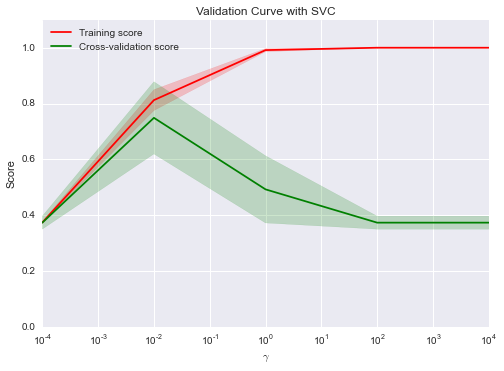

In [127]:
from sklearn.learning_curve import validation_curve

param_range = np.logspace(-4, 4, 5)
train_scores, test_scores = validation_curve(
    SVC(), train_data, target, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVC")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [128]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

NameError: name 'degree' is not defined

In [ ]:
validation_curve?

In [ ]:
sns.set()
pca = PCA().fit(train_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses almost 40% of information (as measured by the explained variance) and that we'd need 6 components to retain 90% of the variance.